<a href="https://colab.research.google.com/github/Tkag0001/Practice_NLP_with_transformer/blob/main/Multilingual_named_entity_recognition_chapter_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The dataset: Pan-x

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [2]:
from datasets import get_dataset_config_names

In [3]:
xtreme_subsets = get_dataset_config_names('xtreme')
print(f"XTREME has {len(xtreme_subsets)} configurations")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


XTREME has 183 configurations


In [4]:
# Search configurations start with "PAN"
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets

['PAN-X.af',
 'PAN-X.ar',
 'PAN-X.bg',
 'PAN-X.bn',
 'PAN-X.de',
 'PAN-X.el',
 'PAN-X.en',
 'PAN-X.es',
 'PAN-X.et',
 'PAN-X.eu',
 'PAN-X.fa',
 'PAN-X.fi',
 'PAN-X.fr',
 'PAN-X.he',
 'PAN-X.hi',
 'PAN-X.hu',
 'PAN-X.id',
 'PAN-X.it',
 'PAN-X.ja',
 'PAN-X.jv',
 'PAN-X.ka',
 'PAN-X.kk',
 'PAN-X.ko',
 'PAN-X.ml',
 'PAN-X.mr',
 'PAN-X.ms',
 'PAN-X.my',
 'PAN-X.nl',
 'PAN-X.pt',
 'PAN-X.ru',
 'PAN-X.sw',
 'PAN-X.ta',
 'PAN-X.te',
 'PAN-X.th',
 'PAN-X.tl',
 'PAN-X.tr',
 'PAN-X.ur',
 'PAN-X.vi',
 'PAN-X.yo',
 'PAN-X.zh']

In [5]:
# we have some .code to represent language such as
# German(de), French(fr), Italian(it), English(en)
from datasets import load_dataset
load_dataset('xtreme', name = 'PAN-X.de')

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [6]:
#keys and propotions each languages
from collections import defaultdict
from datasets import DatasetDict

langs = ['de', 'fr', 'it', 'en']
fracs = [0.629, 0.229, 0.084, 0.059]

# will return a datasetdict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
  # Load monolingual corpus
  ds = load_dataset('xtreme', name = f'PAN-X.{lang}')

  # shuffle and downsample each split according to spoken proportion
  for split in ds:
    panx_ch[lang][split] = (
        ds[split]
        .shuffle(seed = 0) #prevent accidentally bias
        .select(range(int(frac * ds[split].num_rows)))
    )

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
langs

['de', 'fr', 'it', 'en']

In [8]:
# number of samples in training
import pandas as pd
pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
             index = ["Number of trainig examples"])

,de,fr,it,en
Number of trainig examples,12580,4580,1680,1180


In [9]:
# perform zero-shot cross-lingual transfer to German
element = panx_ch['de']['train'][0]
for key, value in element.items():
  print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [10]:
panx_ch['de']['train'].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None),
 'langs': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [11]:
# ner_tags column corresponds to the mapping of each entity to a class ID.
# Let's create a new column with the familiar LOC, PER, and ORG tags.

for key, value in panx_ch['de']['train'].features.items():
  print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [12]:
tags = panx_ch['de']['train'].features['ner_tags'].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [13]:
# we use ClassLabel.int2str() in chapter 2 to create new column with class names for each tag
def create_tag_names(batch):
  return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch['de'].map(create_tag_names)

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [14]:
panx_de

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
})

In [15]:
de_example = panx_de["train"][2]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],['Tokens','Tags'])

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
Tokens,Dirigenten,von,Weltruf,wie,Wilhelm,Furtwängler,",",Erich,Kleiber,",",...,haben,seine,Werke,dirigiert,",",zuletzt,besonders,Horst,Stein,.
Tags,O,O,O,O,B-PER,I-PER,O,B-PER,I-PER,O,...,O,O,O,O,O,O,O,B-PER,I-PER,O


In [16]:
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
  for row in dataset["ner_tags_str"]:
    for tag in row:
      if tag.startswith('B'):
        tag_type = tag.split("-")[1]
        split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient = 'index')

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


#Tokenization

In [17]:
# Compare results between BERT and XLM-R tokenizer
from transformers import AutoTokenizer

bert_model_name = 'bert-base-uncased'
xlmr_model_name = 'xlm-roberta-base'
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [18]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [19]:
bert_tokens

['[CLS]', 'jack', 'sparrow', 'loves', 'new', 'york', '!', '[SEP]']

In [20]:
xlmr_tokens

['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']

In [21]:
pd.DataFrame([bert_tokens, xlmr_tokens],index = ['bert', 'xlmr'])

,0,1,2,3,4,5,6,7,8,9
bert,[CLS],jack,sparrow,loves,new,york,!,[SEP],None,None
xlmr,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>


**We can see that instead of using [CLS], [SEP], xlmr use s and /s. It's like html tag**

# The tokenizer pipeline
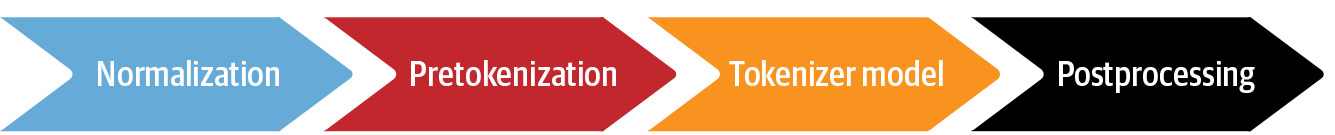

# The SentencePiece Tokenizer

In [22]:
# The weakness of previous model word piece, it lost the infor mation of
# whitespace between "York" and "!". With SentencePiece, the character '_'
# represent whitespace, so the model can detect where whitespace
''.join(xlmr_tokens).replace(u'\u2581',' ')

'<s> Jack Sparrow loves New York!</s>'

# Transformers for Named Entity Recognition

## The Anatomy of the Transformers Model Class
In normally, for our task, we choose a model and replace the last layer of it with one that is suitable for your task. This last layer is called model head.

A model combines parts: body and head

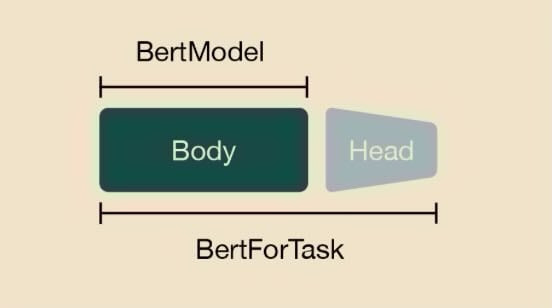

#Creating a Custom Model for Token Classification

In [23]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

In [24]:
# we use RoBerta as the base model, but augmented with settings specific to XLM-R
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
  config_class = XLMRobertaConfig

  def __init__(self, config):
    super().__init__(config)
    self.num_labels = config.num_labels
    # Load model body
    self.roberta = RobertaModel(config, add_pooling_layer = False)
    # Set add_pooling_layer = False to ensure all hidden states are returned
    # and not only the one associated with the [CLS] token

    # Set up token classification head
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    # Load and initialize weights
    self.init_weights()

  def forward(self, input_ids = None,
              attention_mask = None,
              token_type_ids = None,
              labels = None, **kwargs):
    # Get outputs (encoder representations) of model body
    outputs = self.roberta(input_ids, attention_mask = attention_mask,
                           token_type_ids = token_type_ids, **kwargs)

    # Define model head (classifier for encoder representation)
    sequence_output = self.dropout(outputs[0])
    logits = self.classifier(sequence_output)

    # Calculate losses
    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

    # Return model output object
    return TokenClassifierOutput(loss = loss, logits = logits,
                                 hidden_states = outputs.hidden_states,
                                 attentions = outputs.attentions)

In [25]:
print(XLMRobertaForTokenClassification.__dict__)

{'__module__': '__main__', 'config_class': <class 'transformers.models.xlm_roberta.configuration_xlm_roberta.XLMRobertaConfig'>, '__init__': <function XLMRobertaForTokenClassification.__init__ at 0x7f76b8b75480>, 'forward': <function XLMRobertaForTokenClassification.forward at 0x7f76b8b745e0>, '__doc__': None}


# Loading a Custom model

In [26]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [27]:
# Load config by AutoConfig
from transformers import AutoConfig

In [28]:
# View original config
xlmr_config_ori = AutoConfig.from_pretrained(xlmr_model_name)
xlmr_config_ori

XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

In [29]:
# View customize config
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels = tags.num_classes,
                                         id2label = index2tag,
                                         label2id = tag2index)

In [30]:
xlmr_config

XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 5,
    "B-ORG": 3,
    "B-PER": 1,
    "I-LOC": 6,
    "I-ORG": 4,
    "I-PER": 2,
    "O": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

In [31]:
import torch

In [32]:
# Load the model weights by inheriting from RobertaPreTrainedModel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config = xlmr_config)
              .to(device))

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
input_ids = xlmr_tokenizer.encode(text, return_tensors = 'pt')
input_ids

tensor([[    0, 21763, 37456, 15555,  5161,     7,  2356,  5753,    38,     2]])

In [38]:
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index = ['Tokens', 'Input IDs'])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [39]:
# Predict the input
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim = -1)
print(f'Number of tokens in sequence: {len(xlmr_tokens)}')
print(f'Shape of outputs: {outputs.shape}')

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [40]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index = ['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER
